The objective is to make graphs that show player, line, or pair performance by varying levels of QoC and QoT. In the past, I've done it with hexbin charts, but here, I'll change things up a little, to show sample size.

In [1]:
players = ['Matt Niskanen', 'Karl Alzner', 'John Carlson', 'Brooks Orpik', 'Dmitry Orlov', 'Nate Schmidt']
team = 'WSH'
startseason = 2015
endseason = 2016
yaxis = 'F QoC Bin'
xaxis = 'F QoT Bin'

In [2]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import seaborn

In [3]:
dfs = []
for season in range(startseason, endseason + 1):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)

In [4]:
grouped = dfs[['Season', 'Player', 'Team', 'TOION(60s)', 'TOIOFF(60s)']].groupby(['Season', 'Player', 'Team']).sum()
grouped['TOI60'] = 60 * grouped['TOION(60s)'] / (grouped['TOION(60s)'] + grouped['TOIOFF(60s)'])
grouped.reset_index(inplace=True)
toi60 = {}
for i in range(len(grouped)):
    s = grouped['Season'].iloc[i]
    t = grouped['Team'].iloc[i]
    p = grouped['Player'].iloc[i]
    toi = grouped['TOI60'].iloc[i]
    if s not in toi60:
        toi60[s] = {}
    if t not in toi60[s]:
        toi60[s][t] = {}
    toi60[s][t][p] = toi

In [5]:
cfbinneddct = {}
for i in range(len(players)):
    player = players[i]
    fopp = []
    fteam = []
    dopp = []
    dteam = []
    cf = []
    ca = []
    for season in range(startseason, endseason + 1):
        for line in pm2.read_team_corsi(team, season):
            if player in pm2.get_home_players(line):
                opponent = line[1][-3:]
                temp = []
                for p in pm2.get_home_players(line, ['F']):
                    if not p == player:
                        temp.append(toi60[season][team][p])
                if len(temp) == 0:
                    temp.append(0)
                fteam.append(mean(temp))

                temp = []
                for p in pm2.get_home_players(line, ['D']):
                    if not p == player:
                        temp.append(toi60[season][team][p])
                if len(temp) == 0:
                    temp.append(0)
                dteam.append(mean(temp))

                temp = []
                for p in pm2.get_road_players(line, ['F']):
                    if not p == player:
                        temp.append(toi60[season][opponent][p])
                if len(temp) == 0:
                    temp.append(0)
                fopp.append(mean(temp))

                temp = []
                for p in pm2.get_road_players(line, ['D']):
                    if not p == player:
                        temp.append(toi60[season][opponent][p])
                if len(temp) == 0:
                    temp.append(0)
                dopp.append(mean(temp))

                if pm2.get_acting_team(line) == team:
                    cf.append(1)
                    ca.append(0)
                else:
                    cf.append(0)
                    ca.append(1)
        print('Done with CF for', season, player)
    oppteamcfdf = pd.DataFrame({'F QoC': fopp, 'D QoC': dopp, 'F QoT': fteam, 'D QoT': dteam, 'CF': cf, 'CA': ca})
    oppteamcfdf['F QoC Bin'] = oppteamcfdf['F QoC'].apply(lambda x: floor(x) + 0.5)
    oppteamcfdf['D QoC Bin'] = oppteamcfdf['D QoC'].apply(lambda x: floor(x) + 0.5)
    oppteamcfdf['F QoT Bin'] = oppteamcfdf['F QoT'].apply(lambda x: floor(x) + 0.5)
    oppteamcfdf['D QoT Bin'] = oppteamcfdf['D QoT'].apply(lambda x: floor(x) + 0.5)
    
    cfbinned = oppteamcfdf[[xaxis, yaxis, 'CF', 'CA']].groupby([xaxis, yaxis]).sum()
    cfbinned.reset_index(inplace=True)
    cfbinned['CFN'] = cfbinned['CF'] + cfbinned['CA']
    cfbinned['CF%'] = cfbinned['CF'] / cfbinned['CFN']
    cfbinned = cfbinned.sort_values(by='CFN', ascending=False)
    cfbinneddct[player] = cfbinned

Done with CF for 2015 Matt Niskanen
Done with CF for 2016 Matt Niskanen
Done with CF for 2015 Karl Alzner
Done with CF for 2016 Karl Alzner
Done with CF for 2015 John Carlson
Done with CF for 2016 John Carlson
Done with CF for 2015 Brooks Orpik
Done with CF for 2016 Brooks Orpik
Done with CF for 2015 Dmitry Orlov
Done with CF for 2016 Dmitry Orlov
Done with CF for 2015 Nate Schmidt
Done with CF for 2016 Nate Schmidt


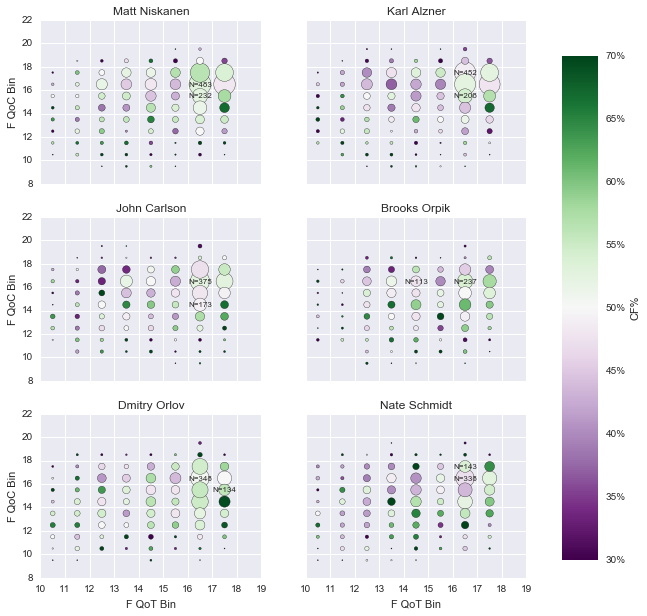

In [6]:
fig, axes = subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 10)
for i in range(len(players)):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    cfbinned = cfbinneddct[players[i]]
    ax.scatter(cfbinned[xaxis], cfbinned[yaxis], s=cfbinned['CFN'], c=cfbinned['CF%'], 
            cmap=plt.cm.PRGn, vmin = 0.3, vmax = 0.7)

    ax.annotate('N={0:d}'.format(cfbinned['CFN'].iloc[0]), 
             xy=(cfbinned[xaxis].iloc[0], cfbinned[yaxis].iloc[0]),
             va = 'center', ha = 'center', size = 8)
    cfbinnedhalved = cfbinned[cfbinned.CFN < cfbinned['CFN'].iloc[0] / 2]
    ax.annotate('N={0:d}'.format(cfbinnedhalved['CFN'].iloc[0]), 
             xy=(cfbinnedhalved[xaxis].iloc[0], cfbinnedhalved[yaxis].iloc[0]),
             va = 'center', ha = 'center', size = 8)

    #cbar = ax.colorbar(orientation='vertical', fraction=0.05)
    #cbar.set_label('CF%')
    #cbar.ax.set_yticklabels(['{0:d}%'.format(int(float(x.get_text()) * 100)) for x in cbar.ax.get_yticklabels()])
    if row == 2:
        ax.set_xlabel(xaxis)
    if col == 0:
        ax.set_ylabel(yaxis)
    endseason2 = str(endseason + 1)[2:]
    ax.set_title('{0:s}'.format(players[i]))
fig.subplots_adjust(right=0.8)
sm = plt.cm.ScalarMappable(cmap=plt.cm.PRGn, norm=plt.Normalize(vmin=0.3, vmax=0.7))
sm._A = []

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('CF%')
cbar.ax.set_yticklabels(['{0:d}%'.format(int(float(x.get_text()) * 100)) for x in cbar.ax.get_yticklabels()])